# JSON API -> Pandas -> Mini Rapor

Bu notebook'ta **API'den JSON veri çekip** Pandas'a aktaracağız ve küçük bir rapor cıkartacağız.

Hedef:
- `requests.get()` ile API çağırmak
- JSON veriyi `DataFrame` yapmak
- Basit `merge` / `groupby`
- 1-2 grafik ile yorum

Kullanılan API'ler (API key istemez):
- JSONPlaceholder (fake data): https://jsonplaceholder.typicode.com  (users, posts)
- Open-Meteo (weather): https://open-meteo.com/en/docs


## Kurulum


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)
sns.set_theme()

print("Hazır!")


Hazır!


## 1) REST API mantığı

- API = Başka bir sistemden veri almak için standart bir yol.
- Biz genelde **GET** ile veri alırız.
- API çoğu zaman **JSON** döndürür.


## 2) Örnek-1: JSONPlaceholder (Users + Posts)


Bu API sahte (fake) veri verir. Test ve ders için.

Kullandığımız endpoint'ler:
- `https://jsonplaceholder.typicode.com/users`
- `https://jsonplaceholder.typicode.com/posts`


### 2.1) Users verisini çek


In [ ]:
url_users = "https://jsonplaceholder.typicode.com/users"

resp = requests.get(url_users, timeout=20)
print("Status code:", resp.status_code)

users_json = resp.json()  # list[dict]
type(users_json), len(users_json)


Status code: 200


(list, 10)

In [ ]:
users_df_raw = pd.DataFrame(users_json)
users_df_raw.head(3)


,id,name,username,email,address,phone,website,company
0,1,Leanne Graham,Bret,Sincere@april.biz,"{'street': 'Kulas Light', 'suite': 'Apt. 556',...",1-770-736-8031 x56442,hildegard.org,"{'name': 'Romaguera-Crona', 'catchPhrase': 'Mu..."
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,"{'street': 'Victor Plains', 'suite': 'Suite 87...",010-692-6593 x09125,anastasia.net,"{'name': 'Deckow-Crist', 'catchPhrase': 'Proac..."
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,"{'street': 'Douglas Extension', 'suite': 'Suit...",1-463-123-4447,ramiro.info,"{'name': 'Romaguera-Jacobson', 'catchPhrase': ..."


### 2.2) Nested (iç içe) JSON'i düzleştir (json_normalize)


In [ ]:
users_df = pd.json_normalize(users_json)

cols = ["id","name","username","email","address.city","company.name"]
users_df = users_df[cols].rename(columns={
    "address.city": "city",
    "company.name": "company"
})

users_df.head()


,id,name,username,email,city,company
0,1,Leanne Graham,Bret,Sincere@april.biz,Gwenborough,Romaguera-Crona
1,2,Ervin Howell,Antonette,Shanna@melissa.tv,Wisokyburgh,Deckow-Crist
2,3,Clementine Bauch,Samantha,Nathan@yesenia.net,McKenziehaven,Romaguera-Jacobson
3,4,Patricia Lebsack,Karianne,Julianne.OConner@kory.org,South Elvis,Robel-Corkery
4,5,Chelsey Dietrich,Kamren,Lucio_Hettinger@annie.ca,Roscoeview,Keebler LLC


### 2.3) Posts verisini çek


In [ ]:
url_posts = "https://jsonplaceholder.typicode.com/posts"

resp = requests.get(url_posts, timeout=20)
print("Status code:", resp.status_code)

posts_json = resp.json()
posts_df = pd.DataFrame(posts_json)

posts_df.head()


Status code: 200


,userId,id,title,body
0,1,1,sunt aut facere repellat provident occaecati e...,quia et suscipit\nsuscipit recusandae consequu...
1,1,2,qui est esse,est rerum tempore vitae\nsequi sint nihil repr...
2,1,3,ea molestias quasi exercitationem repellat qui...,et iusto sed quo iure\nvoluptatem occaecati om...
3,1,4,eum et est occaecati,ullam et saepe reiciendis voluptatem adipisci\...
4,1,5,nesciunt quas odio,repudiandae veniam quaerat sunt sed\nalias aut...


### 2.4) Merge (JOIN mantığı): Posts + Users


In [ ]:
df = posts_df.merge(users_df, left_on="userId", right_on="id", how="left")
df = df.rename(columns={"id_x":"post_id", "id_y":"user_id"})
df[["post_id","userId","title","name","city","company"]].head()


,post_id,userId,title,name,city,company
0,1,1,sunt aut facere repellat provident occaecati e...,Leanne Graham,Gwenborough,Romaguera-Crona
1,2,1,qui est esse,Leanne Graham,Gwenborough,Romaguera-Crona
2,3,1,ea molestias quasi exercitationem repellat qui...,Leanne Graham,Gwenborough,Romaguera-Crona
3,4,1,eum et est occaecati,Leanne Graham,Gwenborough,Romaguera-Crona
4,5,1,nesciunt quas odio,Leanne Graham,Gwenborough,Romaguera-Crona


### 2.5) Mini rapor: Kişi başına post sayısı


In [ ]:
post_count = df.groupby(["user_id","name","city"])["post_id"].count().reset_index()
post_count = post_count.rename(columns={"post_id":"post_count"}).sort_values("post_count", ascending=False)
post_count.head(10)


,user_id,name,city,post_count
0,1,Leanne Graham,Gwenborough,10
1,2,Ervin Howell,Wisokyburgh,10
2,3,Clementine Bauch,McKenziehaven,10
3,4,Patricia Lebsack,South Elvis,10
4,5,Chelsey Dietrich,Roscoeview,10
5,6,Mrs. Dennis Schulist,South Christy,10
6,7,Kurtis Weissnat,Howemouth,10
7,8,Nicholas Runolfsdottir V,Aliyaview,10
8,9,Glenna Reichert,Bartholomebury,10
9,10,Clementina DuBuque,Lebsackbury,10


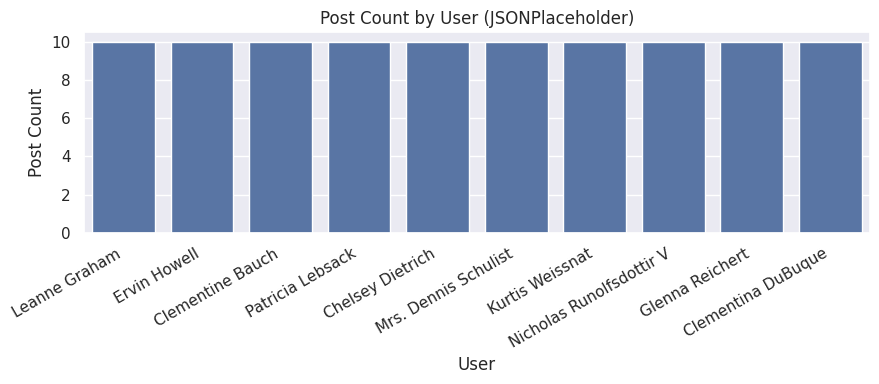

In [ ]:
plt.figure(figsize=(9,4))
sns.barplot(data=post_count, x="name", y="post_count")
plt.title("Post Count by User (JSONPlaceholder)")
plt.xlabel("User")
plt.ylabel("Post Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


### 2.6) Basit özet


- API'den JSON aldık.
- JSON'u DataFrame yaptık.
- Nested alanları düzleştirdik.
- Merge ile tabloyu zenginleştirdik.
- Groupby ile rapor çıkardık.


---


## 3) Örnek-2: Open-Meteo (İstanbul hava durumu JSON)


Bu API gerçek hava durumu verisi verir ve **API key istemez**.

Endpoint:
- `https://api.open-meteo.com/v1/forecast`

İstanbul koordinat:
- lat = 41.0082
- lon = 28.9784


### 3.1) API cağrısını yap (params ile)


In [ ]:
url = "https://api.open-meteo.com/v1/forecast"

params = {
    "latitude": 41.0082,
    "longitude": 28.9784,
    "hourly": "temperature_2m,precipitation",
    "timezone": "Europe/Istanbul"
}

resp = requests.get(url, params=params, timeout=30)
print("Status code:", resp.status_code)

weather = resp.json()
weather.keys()


Status code: 200


dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])

### 3.2) JSON -> DataFrame (hourly)


In [ ]:
hourly = weather["hourly"]

wdf = pd.DataFrame({
    "time": pd.to_datetime(hourly["time"]),
    "temp_c": hourly["temperature_2m"],
    "precip": hourly["precipitation"]
})

wdf.head()


,time,temp_c,precip
0,2026-01-27 00:00:00,11.2,0.1
1,2026-01-27 01:00:00,10.7,0.0
2,2026-01-27 02:00:00,11.1,0.0
3,2026-01-27 03:00:00,12.3,0.0
4,2026-01-27 04:00:00,12.3,0.0


### 3.3) Son 48 saatlik sıcaklık grafiği


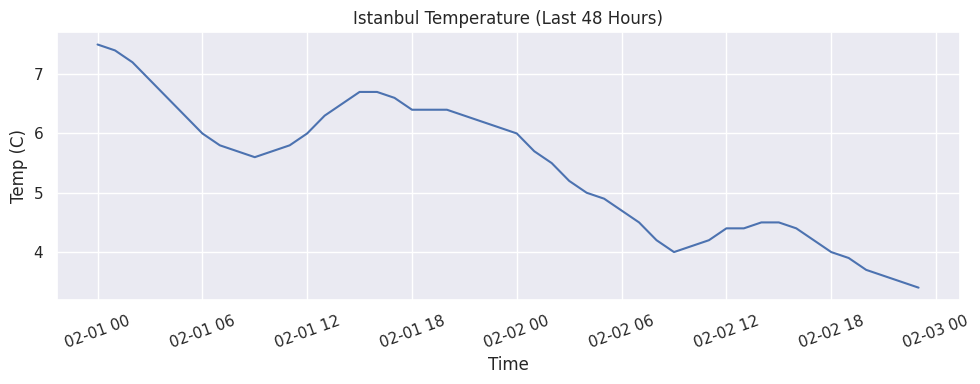

In [ ]:
last48 = wdf.tail(48)

plt.figure(figsize=(10,4))
sns.lineplot(data=last48, x="time", y="temp_c")
plt.title("Istanbul Temperature (Last 48 Hours)")
plt.xlabel("Time")
plt.ylabel("Temp (C)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 3.4) Temel istatistik


In [ ]:
wdf[["temp_c","precip"]].describe()


,temp_c,precip
count,168.000000,168.000000
mean,9.347024,0.358690
std,3.147700,0.475036
min,3.400000,0.000000
25%,6.675000,0.000000
50%,9.600000,0.100000
75%,12.300000,0.600000
max,14.900000,2.400000


---


## 4) Bonus: API hatasina karsi try/except


In [ ]:
def safe_get_json(url, params=None):
    try:
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        return r.json()
    except requests.exceptions.RequestException as e:
        print("API hatasi:", e)
        return None

data = safe_get_json("https://jsonplaceholder.typicode.com/users")
print("Data geldi mi?", data is not None)


Data geldi mi? True
